<div align = "center">

AML Assignment 1 : SMS Spam Classification Prototype 

Part II - Model Training

Trishita Patra

</div>

- The notebook trains three models on `train.csv`:
    - Logistic Regression: Interpretable and a strong baseline for linear text classification.
    - Naive Bayes Classifier: A probabilistic model effective on high-dimensional sparse text data.
    - Linear SVM: Maximizes class separation and often achieves high performance in text classification tasks.

- Feature extraction: Raw text is converted into numerical features using TF-IDF (Term Frequency–Inverse Document Frequency). The `TfidfVectorizer` is embedded within a scikit-learn `Pipeline`, ensuring that feature extraction is learned from the training data and consistently applied to validation and test sets during model training and evaluation.
    - TF-IDF (Term Frequency–Inverse Document Frequency) converts text into numerical features by weighting words based on their importance within a document and across the corpus, emphasizing discriminative terms while downweighting common ones.
    - Unigram TF-IDF offers a strong baseline with lower dimensionality and sparsity, enabling efficient training and better generalization for linear models compared to higher-order n-grams.

- Fine-tunes hyperparameters of each model.
    - Logistic Regression (`C`): Controls the strength of regularization; smaller values increase regularization, larger values allow the model to fit the training data more closely.
    - Naive Bayes (`alpha`): Controls Laplace smoothing; higher values reduce the impact of rare words and help prevent zero probabilities.
    - Linear SVM (`C`): Controls the trade-off between maximizing the margin and minimizing classification error; larger values prioritize fitting the training data.
- Displays evaluation metrics. Based on validation F1-score, best-tuned versions of Logistic Regression, Naive Bayes, and Linear SVM are then treated as the benchmark models.
- Three benchmark models are evaluated on the test set, and best (by Test F1) is chosen.



### Required Libraries

In [3]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

### Helper Functions

In [2]:
# Load dataset splits
def load_split(file_path: str) -> pd.DataFrame:
    return pd.read_csv(file_path)

# Fit model to training data
def fit_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

# Evaluate model with multiple metrics
def compute_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred)
    }

# Hyperparameter tuning using GridSearchCV | F1 Score on validation set
def tune_and_evaluate_model(
    model_name,
    param_values,
    X_train, y_train,
    X_val, y_val
):
    records = []

    for param in param_values:
        if model_name == "LogisticRegression":
            model = Pipeline([
                ("tfidf", TfidfVectorizer()),
                ("clf", LogisticRegression(C=param, max_iter=1000))
            ])

        elif model_name == "NaiveBayes":
            model = Pipeline([
                ("tfidf", TfidfVectorizer()),
                ("clf", MultinomialNB(alpha=param))
            ])

        elif model_name == "LinearSVM":
            model = Pipeline([
                ("tfidf", TfidfVectorizer()),
                ("clf", LinearSVC(C=param))
            ])

        model.fit(X_train, y_train)

        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)

        train_metrics = compute_metrics(y_train, train_pred)
        val_metrics = compute_metrics(y_val, val_pred)

        records.append({
            "param": param,
            **{f"train_{k}": v for k, v in train_metrics.items()},
            **{f"val_{k}": v for k, v in val_metrics.items()},
            "model": model
        })

    df = pd.DataFrame(records)

    best_row = df.loc[df["val_f1"].idxmax()]
    best_model = best_row["model"]

    return df, best_model, best_row

### Training and Evaluation

In [4]:
if __name__ == "__main__":

    # Load data
    train_df = load_split("train.csv")
    val_df = load_split("validation.csv")
    test_df = load_split("test.csv")

    X_train, y_train = train_df["text"], train_df["label"]
    X_val, y_val = val_df["text"], val_df["label"]
    X_test, y_test = test_df["text"], test_df["label"]

    model_configs = {
        "LogisticRegression": [0.1, 0.5, 1, 5, 10],
        "NaiveBayes": [0.1, 0.5, 1.0, 1.5, 2.0],
        "LinearSVM": [0.1, 0.5,1, 5, 10]
    }

    model_results = {}
    best_models = {}

### Visualizating Hyperparameter Tuning

C:\Users\trish\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\trish\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\trish\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\trish\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
 

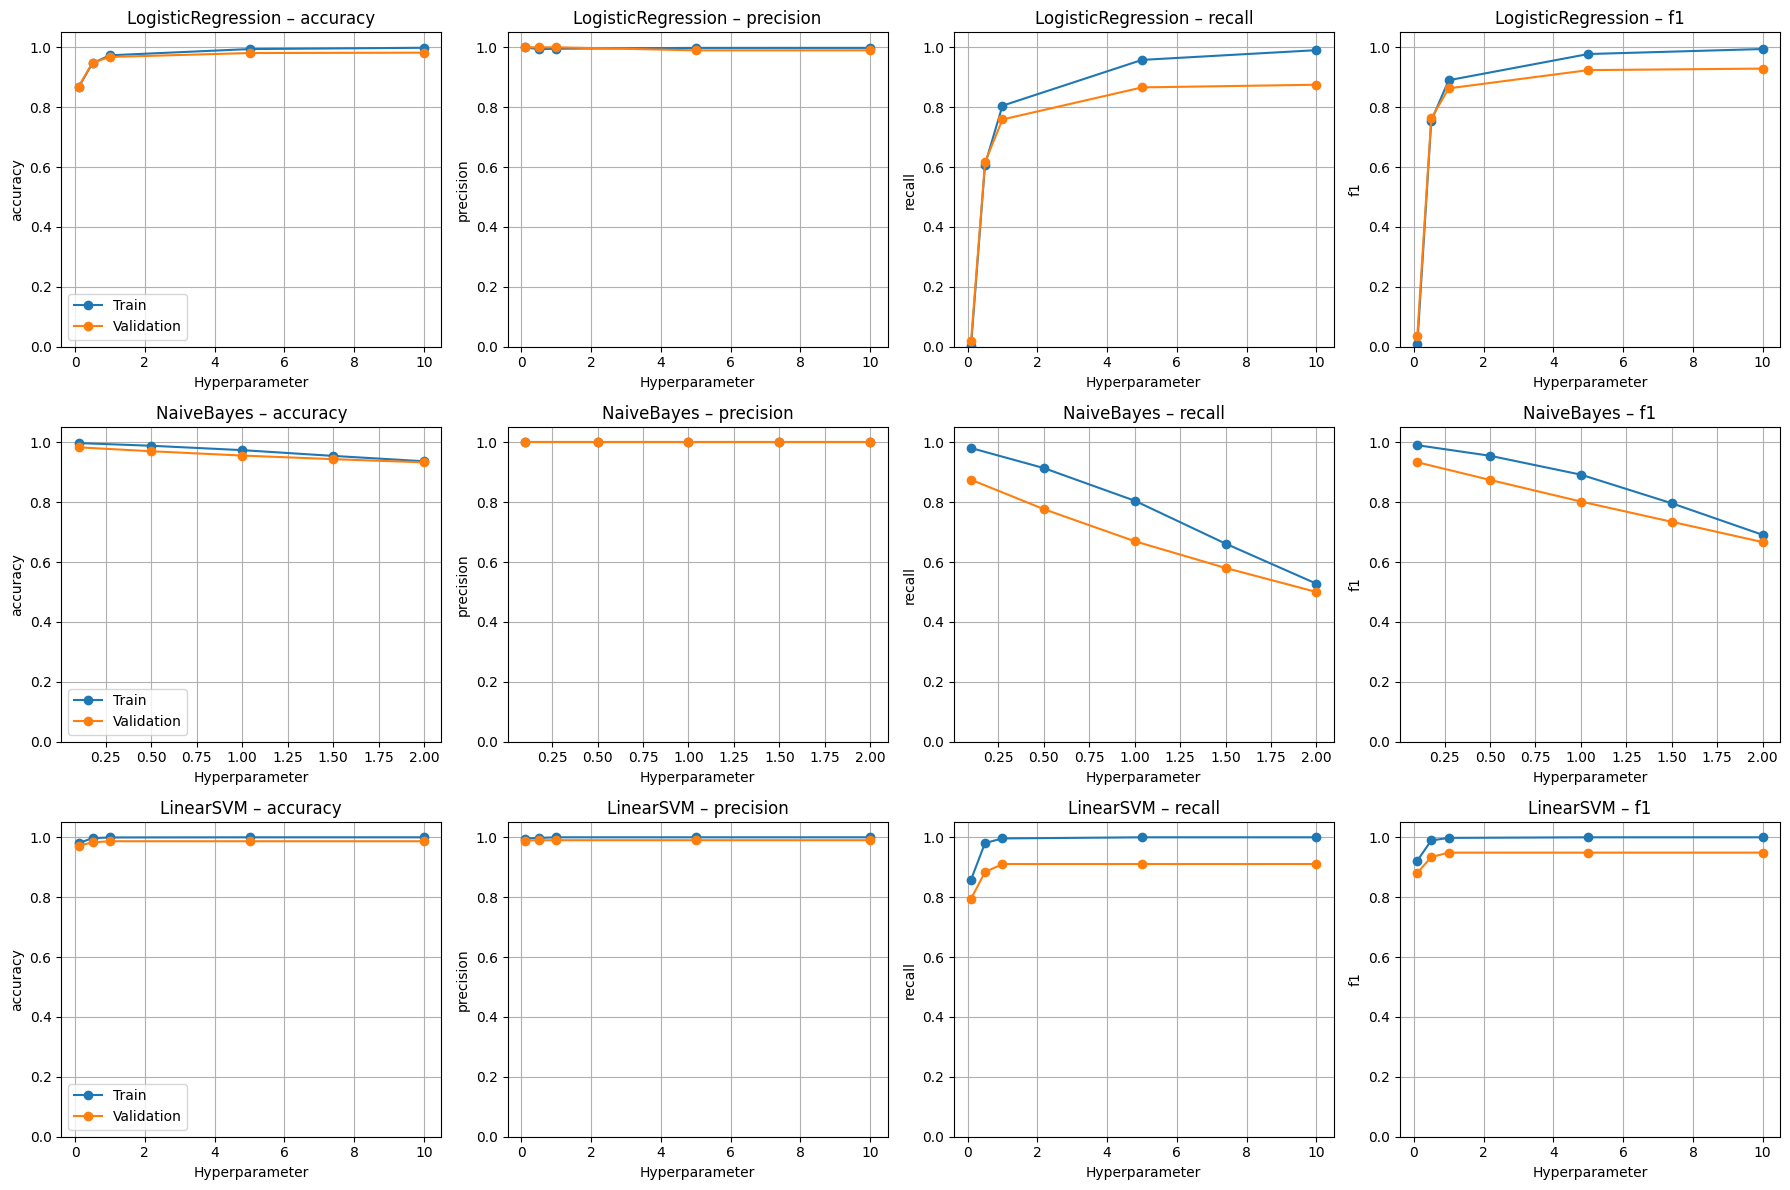

In [5]:
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
metrics = ["accuracy", "precision", "recall", "f1"]

for row_idx, (model_name, params) in enumerate(model_configs.items()):
        df, best_model, best_row = tune_and_evaluate_model(
            model_name, params, X_train, y_train, X_val, y_val
        )

        model_results[model_name] = df
        best_models[model_name] = best_model

        for col_idx, metric in enumerate(metrics):
            ax = axes[row_idx, col_idx]

            ax.plot(df["param"], df[f"train_{metric}"], label="Train", marker="o")
            ax.plot(df["param"], df[f"val_{metric}"], label="Validation", marker="o")

            ax.set_title(f"{model_name} – {metric}")
            ax.set_xlabel("Hyperparameter")
            ax.set_ylabel(metric)
            ax.set_ylim(0, 1.05)
            ax.grid(True)

            if col_idx == 0:
                ax.legend()

plt.tight_layout()    
plt.show()


- Logistic Regression: At low values of the hyperparameter, the model underfits and misses spam (low recall); increasing it improves recall and F1 until performance stabilizes, with no strong signs of overfitting (plateau).
- Naive Bayes: Higher smoothing leads to underfitting, causing recall and F1 to drop because the model becomes too conservative in predicting spam.
- Linear SVM: Achieves high performance quickly and shows minimal train–validation gap, indicating good generalization.
- Precision is consistently high because the dataset is imbalanced (only ~13% spam), so models are cautious about predicting the minority class, leading to very few false positives but making recall the main challenge.

### Best Model

Best Parameter Results (by Validation F1)

Model: LogisticRegression
Validation Metrics: {'accuracy': 0.9821, 'precision': 0.9899, 'recall': 0.875, 'f1': 0.9289}
Test Metrics:       {'accuracy': 0.9856, 'precision': 0.9902, 'recall': 0.9018, 'f1': 0.9439}

Model: NaiveBayes
Validation Metrics: {'accuracy': 0.9833, 'precision': 1.0, 'recall': 0.875, 'f1': 0.9333}
Test Metrics:       {'accuracy': 0.9868, 'precision': 1.0, 'recall': 0.9018, 'f1': 0.9484}

Model: LinearSVM
Validation Metrics: {'accuracy': 0.9868, 'precision': 0.9903, 'recall': 0.9107, 'f1': 0.9488}
Test Metrics:       {'accuracy': 0.9868, 'precision': 0.981, 'recall': 0.9196, 'f1': 0.9493}

Best Overall Model (by Test F1): LinearSVM


<Figure size 1000x600 with 0 Axes>

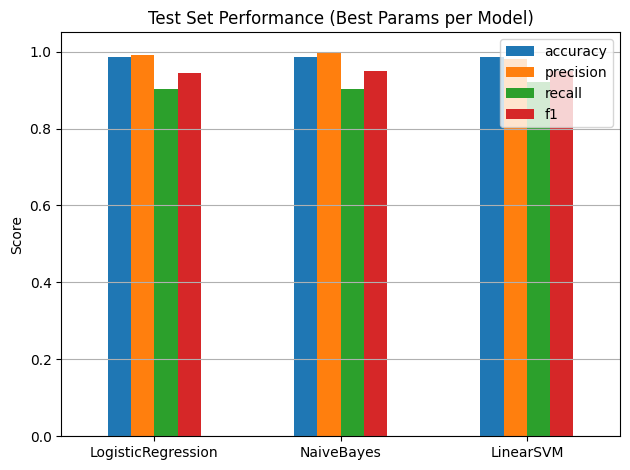

In [7]:
test_metrics_summary = {}

print("Best Parameter Results (by Validation F1)")

for model_name, model in best_models.items():
        val_pred = model.predict(X_val)
        test_pred = model.predict(X_test)

        val_metrics = compute_metrics(y_val, val_pred)
        test_metrics = compute_metrics(y_test, test_pred)

        test_metrics_summary[model_name] = test_metrics

        print(f"\nModel: {model_name}")
        print("Validation Metrics:", {k: round(v, 4) for k, v in val_metrics.items()})
        print("Test Metrics:      ", {k: round(v, 4) for k, v in test_metrics.items()})

best_overall_model = max(
        test_metrics_summary,
        key=lambda m: test_metrics_summary[m]["f1"]
    )
print(f"\nBest Overall Model (by Test F1): {best_overall_model}")

test_df = pd.DataFrame(test_metrics_summary).T

plt.figure(figsize=(10, 6))
test_df.plot(kind="bar")
plt.title("Test Set Performance (Best Params per Model)")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1.05)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


- All three models achieve very similar performance on the test set, with F1-scores differing by a very small margin, indicating that the problem is well-solved by multiple linear text classifiers.
- Linear SVM is selected as the best model with a marginally better balance between precision and recall.
- Given the negligible differences, model choice could reasonably be guided by secondary factors such as interpretability (Logistic Regression) or simplicity and speed (Naive Bayes).